📊 Final Results:

---

📚 Total books processed: 388

✅ Successful downloads: 336

❌ Failed downloads: 52

📈 Success rate: 86.6%


In [21]:
from pathlib import Path

audio_save_path = Path("../data/audio/raw/")
text_save_path = Path("../data/text/pdf/")

In [22]:
audio_dirs = [d for d in audio_save_path.iterdir() if d.is_dir()]
text_files = text_save_path.glob("**/*.pdf")

text_files = [f for f in text_files if f.is_file()]
audio_dirs = [d for d in audio_dirs if d.is_dir()]

len(text_files), len(audio_dirs), text_files[:5], audio_dirs[:5]

(281,
 326,
 [PosixPath('../data/text/pdf/cay-bach-buon.pdf'),
  PosixPath('../data/text/pdf/thuyet-phuc-bang-tam-ly.pdf'),
  PosixPath('../data/text/pdf/nho.pdf'),
  PosixPath('../data/text/pdf/dong-tien-hanh-phuc.pdf'),
  PosixPath('../data/text/pdf/mac-ke-no-lam-toi-di.pdf')],
 [PosixPath('../data/audio/raw/bo-cau-khong-dua-thu'),
  PosixPath('../data/audio/raw/nghe-thuat-hieu-thau-tam-ly-nguoi-khac'),
  PosixPath('../data/audio/raw/thay-thai-do-doi-cuoc-doi'),
  PosixPath('../data/audio/raw/ban-co-nam-cho-ngoi'),
  PosixPath('../data/audio/raw/bi-quyet-cua-thanh-cong')])

In [23]:
def get_dir_size(path: Path, print_size: bool = False) -> int:
  size = sum(f.stat().st_size for f in path.rglob("*") if f.is_file())
  if print_size:
    print(f"Directory: {path}, Size: {size / (1024 * 1024):.2f} MB")
  return size


(
  get_dir_size(audio_save_path, print_size=True),
  get_dir_size(text_save_path, print_size=True),
)

Directory: ../data/audio/raw, Size: 73204.68 MB
Directory: ../data/text/pdf, Size: 718.57 MB


(76760669361, 753478283)

In [24]:
def matching_audio_text(text_files, audio_dirs, remove_empty_dirs=False):
  matched_pairs = []
  text_files = sorted(text_files, key=lambda f: f.stem)
  audio_dirs = sorted(audio_dirs, key=lambda d: d.stem)

  i_text, i_audio = 0, 0
  while i_text < len(text_files) and i_audio < len(audio_dirs):
    text_file = text_files[i_text]
    audio_dir = audio_dirs[i_audio]

    if text_file.stem == audio_dir.stem:
      if get_dir_size(audio_dir) == 0:
        if remove_empty_dirs:
          print(f"Removing empty directory: {audio_dir}")
          # Remove the text file if it matches an empty audio directory
          text_file.unlink(missing_ok=True)
          audio_dir.rmdir(missing_ok=True)  # Remove the empty audio directory
        else:
          print(f"Empty directory found: {audio_dir}, move it to unqualified directory")
          text_file.rename(text_save_path.parent / "unqualified" / text_file.name)
          audio_dir.rename(audio_save_path.parent / "unqualified" / audio_dir.name)
      else:
        matched_pairs.append((text_file, audio_dir))
      i_text += 1
      i_audio += 1
    elif text_file.stem < audio_dir.stem:
      if text_file.exists():
        text_file.rename(text_save_path.parent / "unqualified" / text_file.name)
      i_text += 1
    else:
      if audio_dir.exists():
        audio_dir.rename(audio_save_path.parent / "unqualified" / audio_dir.name)
      i_audio += 1

  print(f"Matched pairs: {len(matched_pairs)}")
  return matched_pairs


matched_pairs = matching_audio_text(text_files, audio_dirs, remove_empty_dirs=False)

Matched pairs: 281


In [25]:
matched_pairs[:5]

[(PosixPath('../data/text/pdf/10-bai-hoc-tren-chiec-khan-an.pdf'),
  PosixPath('../data/audio/raw/10-bai-hoc-tren-chiec-khan-an')),
 (PosixPath('../data/text/pdf/10-bi-quyet-thanh-cong-cua-nhung-dien-gia-mc-tai-nang-nhat-the-gioi.pdf'),
  PosixPath('../data/audio/raw/10-bi-quyet-thanh-cong-cua-nhung-dien-gia-mc-tai-nang-nhat-the-gioi')),
 (PosixPath('../data/text/pdf/10-nghich-ly-cuoc-song.pdf'),
  PosixPath('../data/audio/raw/10-nghich-ly-cuoc-song')),
 (PosixPath('../data/text/pdf/10-quy-luat-cuoc-song.pdf'),
  PosixPath('../data/audio/raw/10-quy-luat-cuoc-song')),
 (PosixPath('../data/text/pdf/100-y-tuong-ban-hang-hay-nhat-moi-thoi-dai.pdf'),
  PosixPath('../data/audio/raw/100-y-tuong-ban-hang-hay-nhat-moi-thoi-dai'))]

In [26]:
import pandas as pd
from typing import List, Tuple
from pathlib import Path
from tts_data_pipeline import Book

In [27]:
def update_metadata(
  old_df: pd.DataFrame,
  matched_pairs: List[Tuple[Path, Path]],
  name_new_df: str = "after_download_metadata_version2",
  save_json: bool = True,
  save_csv: bool = True,
) -> pd.DataFrame:
  """
  Update metadata for matched text/audio pairs with optimized performance.

  Args:
      old_df: Original metadata DataFrame
      matched_pairs: List of (text_file, audio_dir) tuples
      name_new_df: Name for output CSV file
      save_json: Whether to save individual JSON files
      save_csv: Whether to save consolidated CSV

  Returns:
      Updated DataFrame with new metadata
  """
  name_to_row = {row["name"]: row for _, row in old_df.iterrows()}
  updated_records = []
  missing_names = []

  # Create output directory if saving JSON files
  if save_json:
    json_output_dir = Path("../data/metadata/book")
    json_output_dir.mkdir(parents=True, exist_ok=True)

  for text_file, audio_dir in matched_pairs:
    name = text_file.stem

    if name not in name_to_row:
      missing_names.append(name)
      continue

    row_dict = name_to_row[name]
    book = Book.from_dict(row_dict)

    # Update paths and sizes
    book.update_paths(
      audio_path=audio_dir,
      text_path=text_file,
    )
    book.update_size(
      audio_size=get_dir_size(audio_dir),
      text_size=text_file.stat().st_size,
    )

    # Save JSON if requested
    if save_json:
      json_path = json_output_dir / f"{name}.json"
      book.save_json(path=json_path)

    # Collect record for batch DataFrame creation
    updated_records.append(book.to_dict())

  # Report missing names at once
  if missing_names:
    print(
      f"Warning: No metadata found for {len(missing_names)} items: {missing_names[:5]}"
    )
    if len(missing_names) > 5:
      print(f"... and {len(missing_names) - 5} more")

  # Create DataFrame in one operation instead of repeated concatenation
  new_df = pd.DataFrame(updated_records, columns=old_df.columns)

  # Save CSV if requested
  if save_csv:
    csv_output_dir = Path("../data/metadata")
    csv_output_dir.mkdir(parents=True, exist_ok=True)
    csv_path = csv_output_dir / f"{name_new_df}.csv"
    new_df.to_csv(csv_path, index=False)

  return new_df

In [28]:
old_metadata_df = pd.read_csv(
  "../data/metadata/able_download_less_10_hour_metadata.csv"
)
# old_metadata_df.head()

In [29]:
after_download_metadata_df = update_metadata(
  old_metadata_df, matched_pairs, save_json=False
)
after_download_metadata_df.head()

,id,name,text_path,audio_path,narrator,duration,author,text_url,audio_url,alignment_path,text_download_url,audio_download_url,sample_rate,quality,word_count,num_sentences,audio_size,text_size
0,a00985dd,10-bai-hoc-tren-chiec-khan-an,../data/text/pdf/10-bai-hoc-tren-chiec-khan-an...,../data/audio/raw/10-bai-hoc-tren-chiec-khan-an,"{'id': '5af6cbeb', 'name': 'Trần Huỳnh Phương ...",2.5039,Don Failla,['https://thuviensachpdf.com/10-bai-hoc-tren-c...,https://sachnoiviet.net/sach-noi/10-bai-hoc-tr...,nan,https://cloud.thuviensachpdf.com/pdf/vi/10-bai...,['https://archive.org/download/10-bai-hoc-tren...,NaN,NaN,NaN,NaN,144734808,347556
1,2c0c221e,10-bi-quyet-thanh-cong-cua-nhung-dien-gia-mc-t...,../data/text/pdf/10-bi-quyet-thanh-cong-cua-nh...,../data/audio/raw/10-bi-quyet-thanh-cong-cua-n...,"[{'id': '047c61b1', 'name': 'Ái Hòa', 'dialect...",4.2244,Carmine Gallo,['https://thuviensachpdf.com/10-bi-quyet-thanh...,https://sachnoiviet.net/sach-noi/10-bi-quyet-t...,nan,https://cloud.thuviensachpdf.com/pdf/vi/10-bi-...,['https://archive.org/download/10-bi-02/10-bi-...,NaN,NaN,NaN,NaN,121662956,1017767
2,7685d9c3,10-nghich-ly-cuoc-song,../data/text/pdf/10-nghich-ly-cuoc-song.pdf,../data/audio/raw/10-nghich-ly-cuoc-song,"[{'id': '2b4c5c3b', 'name': 'Ái Hòa', 'dialect...",3.2611,Kent M. Keith Ph. D.,['https://thuviensachpdf.com/10-nghich-ly-cuoc...,https://sachnoiviet.net/sach-noi/10-nghich-ly-...,nan,https://cloud.thuviensachpdf.com/pdf/vi/10-ngh...,['https://archive.org/download/truyenngan_2019...,NaN,NaN,NaN,NaN,89579482,308308
3,97c03f2e,10-quy-luat-cuoc-song,../data/text/pdf/10-quy-luat-cuoc-song.pdf,../data/audio/raw/10-quy-luat-cuoc-song,"{'id': '6fedc83f', 'name': 'Lê Trang', 'dialec...",2.4194,Dan Sullivan,['https://thuviensachpdf.com/10-quy-luat-cuoc-...,https://sachnoiviet.net/sach-noi/10-quy-luat-c...,nan,https://cloud.thuviensachpdf.com/pdf/vi/10-quy...,['https://archive.org/download/10-quy-07/10-qu...,NaN,NaN,NaN,NaN,70404707,784216
4,9beeb483,100-y-tuong-ban-hang-hay-nhat-moi-thoi-dai,../data/text/pdf/100-y-tuong-ban-hang-hay-nhat...,../data/audio/raw/100-y-tuong-ban-hang-hay-nha...,"{'id': '5286f13d', 'name': 'Bà Già Đọc Sách', ...",4.1975,Ken Langdon,['https://thuviensachpdf.com/100-y-tuong-ban-h...,https://sachnoiviet.net/sach-noi/100-y-tuong-b...,nan,https://cloud.thuviensachpdf.com/pdf/vi/100-y-...,['https://archive.org/download/100-y-1/100-y-1...,NaN,NaN,NaN,NaN,241784365,1121551


In [30]:
import ast

not_enough_part_book_name = []
for book in after_download_metadata_df.itertuples():
  audio_download_urls = ast.literal_eval(book.audio_download_url)
  audio_path = Path(book.audio_path)
  text_path = Path(book.text_path)

  if not audio_path.exists():
    print(f"Audio path does not exist: {audio_path}")
  if not text_path.exists():
    print(f"Text path does not exist: {text_path}")

  if len(audio_download_urls) != len(list(audio_path.glob("*.*"))):
    print(
      f"Mismatch in audio files for {book.name}: {len(audio_download_urls)} URLs vs {len(list(audio_path.glob('*.*')))} files"
    )
    not_enough_part_book_name.append(book.name)
    audio_path.rename(audio_path.parent.parent / "unqualified" / audio_path.name)
    text_path.rename(text_path.parent.parent / "unqualified" / text_path.name)

print(f"Length of metadata before filtering: {len(after_download_metadata_df)}")
after_download_metadata_df = after_download_metadata_df[
  ~after_download_metadata_df["name"].isin(not_enough_part_book_name)
]
print(f"Length of metadata after filtering: {len(after_download_metadata_df)}")

after_download_metadata_df.to_csv(
  "../data/metadata/after_download_metadata.csv", index=False
)

Mismatch in audio files for 100-y-tuong-tiep-thi-tuyet-hay: 7 URLs vs 4 files
Mismatch in audio files for ba-chua-hon: 13 URLs vs 10 files
Mismatch in audio files for bay-buoc-toi-mua-he: 6 URLs vs 1 files
Mismatch in audio files for can-bang-than-tam: 6 URLs vs 5 files
Mismatch in audio files for chua-tau-kim-quy: 15 URLs vs 14 files
Mismatch in audio files for chuyen-co-tich-danh-cho-nguoi-lon: 7 URLs vs 6 files
Mismatch in audio files for lich-su-khan-hoang-mien-nam: 15 URLs vs 14 files
Mismatch in audio files for ngon-den-khong-tat: 6 URLs vs 3 files
Mismatch in audio files for nha-gia-kim: 8 URLs vs 4 files
Mismatch in audio files for nho: 7 URLs vs 6 files
Mismatch in audio files for nhung-chang-trai-xau-tinh: 4 URLs vs 3 files
Mismatch in audio files for suong-khoi-que-nha: 7 URLs vs 6 files
Mismatch in audio files for totto-chan-ben-cua-so: 4 URLs vs 1 files
Length of metadata before filtering: 281
Length of metadata after filtering: 268


## Analysis of results:


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

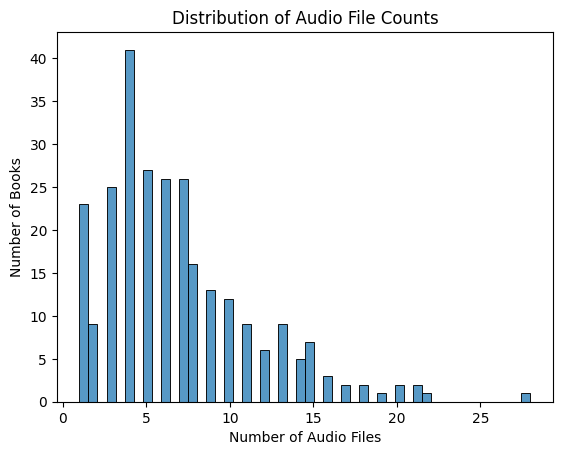

In [32]:
# The histogram of audio file counts per book
audio_counts = after_download_metadata_df["audio_download_url"].apply(
  lambda x: len(ast.literal_eval(x))
)
sns.histplot(audio_counts, bins=50, edgecolor="black")
plt.xlabel("Number of Audio Files")
plt.ylabel("Number of Books")
plt.title("Distribution of Audio File Counts")
plt.show()

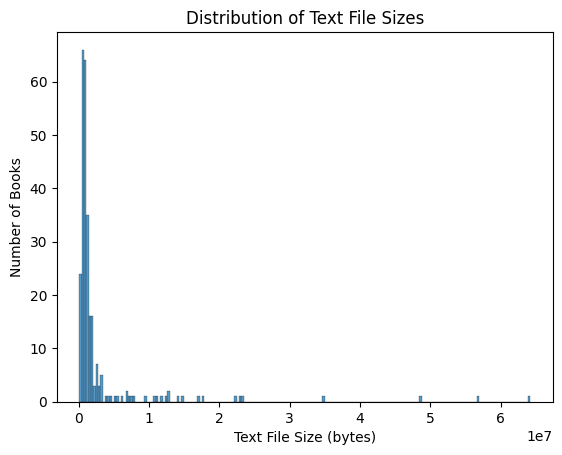

In [33]:
# The histogram of text file sizes
text_sizes = after_download_metadata_df["text_size"]
sns.histplot(text_sizes, edgecolor="black")
plt.xlabel("Text File Size (bytes)")
plt.ylabel("Number of Books")
plt.title("Distribution of Text File Sizes")
plt.show()

In [34]:
after_download_metadata_df.iloc[text_sizes.idxmax()]

id                                                             34e830b3
name                      henry-ford-va-ford-dat-the-gioi-len-4-banh-xe
text_path             ../data/text/pdf/henry-ford-va-ford-dat-the-gi...
audio_path            ../data/audio/raw/henry-ford-va-ford-dat-the-g...
narrator              {'id': 'ea7c41a5', 'name': 'Thùy Duyên', 'dial...
duration                                                         6.9192
author                                                     Lê Minh Toàn
text_url              ['https://thuviensachpdf.com/henry-ford-va-for...
audio_url             https://sachnoiviet.net/sach-noi/henry-ford-va...
alignment_path                                                      nan
text_download_url     https://cloud.thuviensachpdf.com/pdf/vi/henry-...
audio_download_url    ['https://archive.org/download/henry-ford-va-f...
sample_rate                                                         NaN
quality                                                         

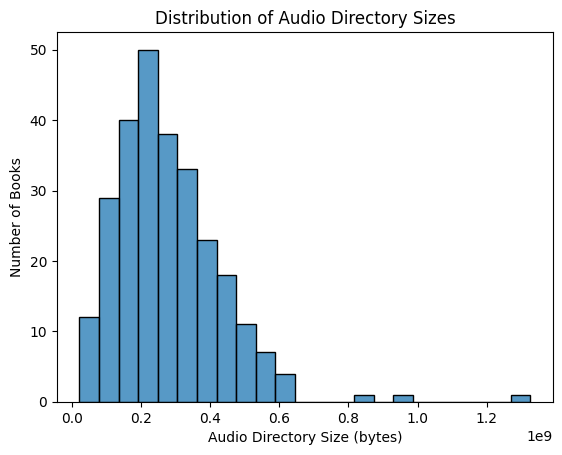

In [35]:
# The histogram of audio directory sizes
audio_sizes = after_download_metadata_df["audio_size"]
sns.histplot(audio_sizes, edgecolor="black")
plt.xlabel("Audio Directory Size (bytes)")
plt.ylabel("Number of Books")
plt.title("Distribution of Audio Directory Sizes")
plt.show()

In [36]:
after_download_metadata_df.iloc[
  audio_sizes.idxmax()
]  # The book with the largest audio directory size is the book having the largest duration

id                                                             8ea24379
name                                       dung-hoang-tuong-ve-bien-lon
text_path             ../data/text/pdf/dung-hoang-tuong-ve-bien-lon.pdf
audio_path               ../data/audio/raw/dung-hoang-tuong-ve-bien-lon
narrator              {'id': '25e5d1f5', 'name': 'Thùy Châu', 'diale...
duration                                                         5.0392
author                                                        Alan Phan
text_url              ['https://thuviensachpdf.com/dung-hoang-tuong-...
audio_url             https://sachnoiviet.net/sach-noi/dung-hoang-tu...
alignment_path                                                      nan
text_download_url     https://cloud.thuviensachpdf.com/pdf/vi/dung-h...
audio_download_url    ['https://archive.org/download/dung-hoang-tuon...
sample_rate                                                         NaN
quality                                                         

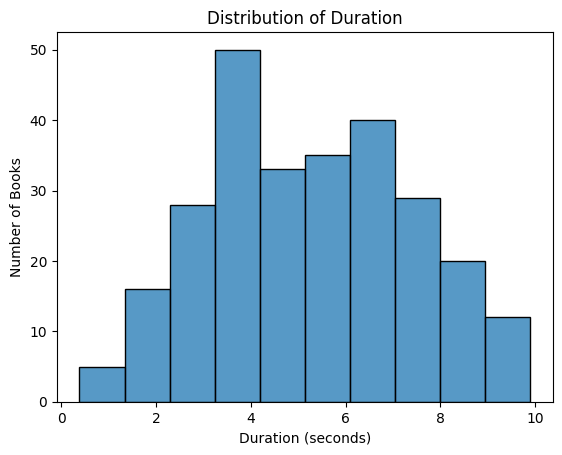

In [37]:
# The histogram of duration
duration = after_download_metadata_df["duration"]
sns.histplot(duration, edgecolor="black")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Books")
plt.title("Distribution of Duration")
plt.show()

In [38]:
duration.describe()

count    268.000000
mean       5.268838
std        2.145490
min        0.379200
25%        3.631525
50%        5.212200
75%        6.986650
max        9.898100
Name: duration, dtype: float64

In [39]:
duration.sum()

np.float64(1412.0486)